In [1]:
from openff.toolkit import Molecule, Topology, ForceField
from openff.interchange import Interchange
from openmm.unit import kelvin, picoseconds, nanometer, kilojoule, mole, dalton, angstrom, kilocalorie, nanosecond, femtosecond
from openmm import LangevinIntegrator, State, VerletIntegrator
from openmm.app import Simulation, DCDReporter, StateDataReporter, CheckpointReporter
from openmm.unit.quantity import Quantity
from sys import stdout
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import copy

In [2]:
from openmm.app.forcefield import ForceField as OpenMMForceField
from openmm.app import PDBFile

In [3]:
def animate_md(r:np.array, topology):
    # Setup the figure and axes...
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5), ylabel='Angstrom',
           xlabel='Angstrom', title=f'{next(topology.molecules).name} movement')
    
    ## drawing and animating 
    scat = ax.scatter(r[0,:,0], r[0,:,1], marker='o', c=range(topology.n_atoms), s=1000)
    
    def animate(i):
        scat.set_offsets(r[100*i])
    
    ani = animation.FuncAnimation(fig, animate, frames=int(n/ 100))
    plt.close()
    return HTML(ani.to_jshtml())

In [4]:
### 3. Choose parameters of the experiment
temperature = 100*kelvin
frictionCoeff = 0  # 1/picoseconds
time_step = 0.0002*picoseconds
total_steps = int(1*picoseconds / time_step)

smiles_explicit_h = Molecule.from_smiles(
    #"[H][C]([H])([H])[C@@]([H])([C](=[O])[O-])[N+]([H])([H])[H]",
    "N1N=NN=N1",
    hydrogens_are_explicit=False,
)
smiles_explicit_h.generate_conformers(n_conformers=1)

sage = ForceField("openff_unconstrained-2.1.0.offxml")
interchange = Interchange.from_smirnoff(sage, [smiles_explicit_h])

positions = interchange.positions.to_openmm()
system = interchange.to_openmm_system()
topology = Topology.from_molecules([smiles_explicit_h])

original_positions = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions())
original_positions_numpy = copy.deepcopy(interchange
                                   .to_openmm_simulation(
                                       LangevinIntegrator(temperature, frictionCoeff, time_step)
                                   )
                                   .context.getState(getPositions=True).getPositions(True))
#positions[0][0] += Quantity(0.05, nanometer)

In [5]:
system_no_blf = interchange.to_openmm_system()
system_no_blf.removeForce(3)  # seems like bond length force is this one currently
integrator = VerletIntegrator(time_step)
simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
simulation_no_blf.context.setPositions(positions)

In [6]:
bonds = sage.get_parameter_handler("Bonds").find_matches(topology)  # k units: kCal / Angstrom **2 / mole; length units: Angstrom
m = Quantity(np.array([[atom.mass.m] for atom in topology.atoms]), dalton)   # Dalton
def get_f(r, topology, bonds):
    f = Quantity(np.zeros_like(r), kilojoule/(nanometer*mole))
    for i in range(topology.n_atoms):
        for j in range(topology.n_atoms):
            if i != j and bonds.get((i,j)):
                rij = r[i] - r[j]
                rij_abs = np.linalg.norm(rij)
                k = bonds.get((i,j)).parameter_type.k.to_openmm()
                r0 = bonds.get((i,j)).parameter_type.length.to_openmm()
                f[i] -= k * (rij_abs - r0) * rij / rij_abs 
    return f


In [7]:
import scipy


def compute_jacobian(r_ini, topology):
    '''The function computes the Jacobian of the spring force evaluated
    at the initial positions of the particles.'''
    n = np.size(r_ini)
    K = Quantity(np.zeros((n, n)), kilocalorie / (mole * angstrom**2))
    for i in range(topology.n_atoms):
        for j in range(topology.n_atoms):
            if i == j:
                for other in np.arange(topology.n_atoms)[np.arange(topology.n_atoms) != i]:
                    RiRother = (r_ini[i] - r_ini[other]).value_in_unit(nanometer)
                    riother = np.linalg.norm(RiRother) ** 2
                    if bonds.get((i,other)):
                        k = bonds.get((i,other))\
                        .parameter_type.k.to_openmm()
                        r0 = bonds.get((i,other))\
                        .parameter_type.length.to_openmm()\
                        .value_in_unit(nanometer) ** 2
                    else:
                        k = Quantity(0, kilocalorie / angstrom ** 2 / mole)
                        r0 = 0
                    l = 4 * k * np.outer(RiRother, RiRother)
                    r = 2 * k * (riother - r0) * np.eye(3)
                    K[i * 3: (i+1) * 3, j * 3: (j+1) * 3] -= l + r
            else:
                RiRj = (r_ini[i] - r_ini[j]).value_in_unit(nanometer)
                rij = np.linalg.norm(RiRj) ** 2
                if bonds.get((i,j)):
                    k = bonds.get((i,j))\
                    .parameter_type.k.to_openmm()
                    r0 = bonds.get((i,j))\
                    .parameter_type.length\
                    .to_openmm().value_in_unit(nanometer) **2
                else:
                    k = Quantity(0, kilocalorie / angstrom ** 2 / mole)
                    r0 = 0
                l = 4 * k * np.outer(RiRj, RiRj)
                r = 2 * k * (rij - r0) * np.eye(3)
                K[i * 3: (i+1) * 3, j * 3: (j+1) * 3] = l + r 
    return K

def get_rotation(v, u):
    '''Compute an approximate rotation between two vectors.
    This is the first approach described in [1] as using geometric algebra.
    [1] M. Müller, J. Dorsey, L. McMillan, R. Jagnow, and B. Cutler, “Stable real-time deformations,” 
    in Proceedings of the 2002 ACM SIGGRAPH/Eurographics symposium on Computer animation, 
    San Antonio Texas: ACM, Jul. 2002, pp. 49–54. doi: 10.1145/545261.545269.
    '''
    F = u.T @ np.array(v)  # .T turns Quantity into np.array. array @ Quantity not defined
    U, S, Vh = scipy.linalg.svd(F)
    R = Vh.T @ U.T
    return R

    
def get_repeated_rot(r_current, r_old, base_atom_idx, n_atoms, topology):
    '''Compute the rotation between the old positions r_old and the current positions r_current
    with respect to atoms bonded to the atom with base_atom_idx. Then insert that rotation block wise
    into a large rotation matrix for the entire molecule.
    '''
    RxLarge = np.zeros((n_atoms, n_atoms))
    Rx_invLarge = np.zeros((n_atoms, n_atoms))
    
    relevant_atoms = [base_atom_idx] + [bonded_atom.molecule_atom_index for
                            bonded_atom in topology.atom(base_atom_idx).bonded_atoms]
    Rx = get_rotation(r_current[relevant_atoms], r_old[relevant_atoms])
    RxLarge = np.kron(np.eye(n_atoms), Rx)
    Rx_invLarge = np.kron(np.eye(n_atoms), Rx.T)
    return Quantity(RxLarge), Quantity(Rx_invLarge), Quantity(Rx)

In [8]:
def get_Rx(r_current, r_old, topology):
    RxLarge = np.zeros((r_current.size, r_current.size))
    Rx_invLarge = np.zeros((r_current.size, r_current.size))
    for i in range(topology.n_atoms):
        relevant_atoms = list(range(topology.n_atoms))
        Rx = get_rotation(r_current[relevant_atoms], r_old[relevant_atoms])
        RxLarge[i*3: (i+1)*3, i*3: (i+1)*3] = Rx
        Rx_invLarge[i*3: (i+1)*3, i*3: (i+1)*3] = Rx.T
    return RxLarge, Rx_invLarge

## Separate into fast and slow parts
$$\ddot{R}(t) + AR(t) + M^{-1}\tilde{G}(R(t)) = 0,$$
with $A=M^{-1}QKQ^T$ not necessarily symmetric and $\tilde{G}=G(R(t)) - QKR_0$. $G(R(t))$ is the sum of the forces from OpenMM.

Later we will want to compute the square root of the matrix $A$, so it needs to be positive definite. For this Michels et al transform the coordinates from $R(t)$ to $\chi(t) = M^{-1/2}R(t)$. The differential equation then becomes
$$\ddot{\chi}(t) + \Omega^2\chi(t) + \Lambda(\chi(t)),$$
with $\Omega^2=M^{1/2}AM^{-1/2}$ symmetric.

In [9]:
def matvec_quantity(A, b):
    unit = A.unit * b.unit
    value = A.value_in_unit(A.unit) @ b.value_in_unit(b.unit).flatten()
    return Quantity(value, unit)

def matmul_quantity(A, B):
    unit = A.unit * B.unit
    value = A.value_in_unit(A.unit) @ B.value_in_unit(B.unit)
    return Quantity(value, unit)

In [10]:
system_no_blf = interchange.to_openmm_system()
system_no_blf.removeForce(3)  # seems like bond length force is this one currently
integrator = VerletIntegrator(time_step)
simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
simulation_no_blf.context.setPositions(positions)

In [11]:
K = compute_jacobian(original_positions, topology)
M_inv = Quantity(np.kron(np.diag(1 / m.flatten()), np.eye(3)), 1 / m.unit)
f0 = get_f(original_positions, topology, bonds)
M_sqrt = Quantity(np.kron(np.diag(np.sqrt(m.flatten())), np.eye(3)), m.unit ** (1/2))
M_sqrt_inv = Quantity(np.kron(np.diag(1 / np.sqrt(m.flatten())), np.eye(3)), m.unit ** (-1/2))

In [12]:
r = np.empty((total_steps, topology.n_atoms, 3)) 
for n in range(total_steps):
    state = simulation_no_blf.context.getState(getForces=True, 
                                               getPositions=True, 
                                               getVelocities=True, 
                                               getEnergy=True)
    p = state.getPositions(True)
    v = state.getVelocities(True)
    xi = matvec_quantity(M_sqrt, p.reshape(-1))
    QLarge, Q_invLarge = get_Rx(p, original_positions_numpy, topology)
    QLarge = Quantity(QLarge)
    Q_invLarge = Quantity(Q_invLarge)
    QTsqrtM = matmul_quantity(Q_invLarge, M_sqrt)
    Omega2 = matmul_quantity(Quantity(QTsqrtM.T, QTsqrtM.unit), 
                          matmul_quantity(K, QTsqrtM))
    F = state.getForces(True).reshape(-1)
    G = matmul_quantity(M_sqrt_inv, (F - matmul_quantity(Quantity(QLarge), 
                                             matvec_quantity(K, original_positions_numpy)
                                                        )
                                    )
                       )
    assert(scipy.linalg.cholesky(Omega2))
    v = Quantity(v.flatten() + time_step * M_inv @ (QLarge @ np.array(K) @ \
        (Q_invLarge @ p.flatten())),
                 nanometer / picoseconds)
    
    v = v.reshape((topology.n_atoms,3))
    p = state.getPositions(True) + time_step * v
    simulation_no_blf.context.setPositions(p)
    simulation_no_blf.context.setVelocities(v)
    simulation_no_blf.step(1)
    r[n] = state.getPositions(True) * 10  # nanometer -> angstrom
    if n % 1000 == 0:
        #print(state.getForces())
        print(state.getKineticEnergy())
animate_md(r, topology)

LinAlgError: 1-th leading minor of the array is not positive definite

### It turns out $\Omega^2$ is not symmetric or positive definite in our implementation.
Possibly this is because we are using a different rotation implementation than Michels et al. Let's try the second implementation proposed by Mueller et al.

In [13]:
def get_rotation_v2(u, v):
    '''Compute an approximate rotation between two vectors.
    This is the second approach described in [1]. It is based on something else.
    Assume the particle ``in the center'' of this complex is first in the vectors.
    [1] M. Müller, J. Dorsey, L. McMillan, R. Jagnow, and B. Cutler, “Stable real-time deformations,” 
    in Proceedings of the 2002 ACM SIGGRAPH/Eurographics symposium on Computer animation, 
    San Antonio Texas: ACM, Jul. 2002, pp. 49–54. doi: 10.1145/545261.545269.
    '''
    assert(v.shape[0] > 3)
    assert(v.shape[1] == 3)
    v_edges = v[1:] - v[0]
    u_edges = u[1:] - u[0]
    v1 = v_edges[:3].mean(0)
    v1 = v1 / np.linalg.norm(v1)
    v2 = np.cross(v1, v_edges[0])
    v2 = v2 / np.linalg.norm(v2)
    v3 = np.cross(v1, v2)
    v3 = v3 / np.linalg.norm(v3)
    VT = np.array([v1, v2, v3])
    assert(VT.shape == (3, 3))
    u1 = u_edges[:3].mean(0)
    u1 = u1 / np.linalg.norm(u1)
    u2 = np.cross(u1, u_edges[0])
    u2 = u2 / np.linalg.norm(u2)
    u3 = np.cross(u1, u2)
    u3 = u3 / np.linalg.norm(u3)
    UT = np.array([u1, u2, u3])
    return UT.T @ VT

First let's do a quick sanity check for the rotations produced here.

In [14]:
from scipy.spatial.transform import Rotation as R
r = R.from_euler('x', 88) * R.from_euler('yz', [99, 77]) * R.from_euler('xyz', [11, 33, 55])
a = original_positions_numpy[:4]
b = r.apply(a)
rot = get_rotation_v2(b, a)
approx = (rot.T @ b.T).T
assert(np.all(np.isclose(approx, a)))

Now test again if the matrix is symmetric.

In [15]:
def get_Rx_v2(r_current, r_old, topology):
    RxLarge = np.zeros((r_current.size, r_current.size))
    Rx_invLarge = np.zeros((r_current.size, r_current.size))
    for i in range(topology.n_atoms):
        relevant_atoms = list(range(topology.n_atoms))
        Rx = get_rotation_v2(r_current[relevant_atoms], r_old[relevant_atoms])
        RxLarge[i*3: (i+1)*3, i*3: (i+1)*3] = Rx
        Rx_invLarge[i*3: (i+1)*3, i*3: (i+1)*3] = Rx.T
    return RxLarge, Rx_invLarge

In [16]:
system_no_blf = interchange.to_openmm_system()
system_no_blf.removeForce(3)  # seems like bond length force is this one currently
integrator = VerletIntegrator(time_step)
simulation_no_blf = Simulation(topology.to_openmm(), system_no_blf, integrator)
simulation_no_blf.context.setPositions(positions)

In [17]:
K = compute_jacobian(original_positions, topology)
M_inv = Quantity(np.kron(np.diag(1 / m.flatten()), np.eye(3)), 1 / m.unit)
f0 = get_f(original_positions, topology, bonds)
M_sqrt = Quantity(np.kron(np.diag(np.sqrt(m.flatten())), np.eye(3)), m.unit ** (1/2))
M_sqrt_inv = Quantity(np.kron(np.diag(1 / np.sqrt(m.flatten())), np.eye(3)), m.unit ** (-1/2))

In [18]:
r = np.empty((total_steps, topology.n_atoms, 3)) 
for n in range(total_steps):
    state = simulation_no_blf.context.getState(getForces=True, 
                                               getPositions=True, 
                                               getVelocities=True, 
                                               getEnergy=True)
    p = state.getPositions(True)
    v = state.getVelocities(True)
    xi = matvec_quantity(M_sqrt, p.reshape(-1))
    QLarge, Q_invLarge = get_Rx_v2(p, original_positions_numpy, topology)
    QLarge = Quantity(QLarge)
    Q_invLarge = Quantity(Q_invLarge)
    QTsqrtM = matmul_quantity(Q_invLarge, M_sqrt)
    Omega2 = matmul_quantity(Quantity(QTsqrtM.T, QTsqrtM.unit), 
                          matmul_quantity(K, QTsqrtM))
    F = state.getForces(True).reshape(-1)
    G = matmul_quantity(M_sqrt_inv, (F - matmul_quantity(Quantity(QLarge), 
                                             matvec_quantity(K, original_positions_numpy)
                                                        )
                                    )
                       )
    assert(scipy.linalg.cholesky(Omega2))
    v = Quantity(v.flatten() + time_step * M_inv @ (QLarge @ np.array(K) @ \
        (Q_invLarge @ p.flatten())),
                 nanometer / picoseconds)
    
    v = v.reshape((topology.n_atoms,3))
    p = state.getPositions(True) + time_step * v
    simulation_no_blf.context.setPositions(p)
    simulation_no_blf.context.setVelocities(v)
    simulation_no_blf.step(1)
    r[n] = state.getPositions(True) * 10  # nanometer -> angstrom
    if n % 1000 == 0:
        #print(state.getForces())
        print(state.getKineticEnergy())
animate_md(r, topology)

LinAlgError: 1-th leading minor of the array is not positive definite

### Similarly to before the matrix $\Omega^2$ is not positive definite.

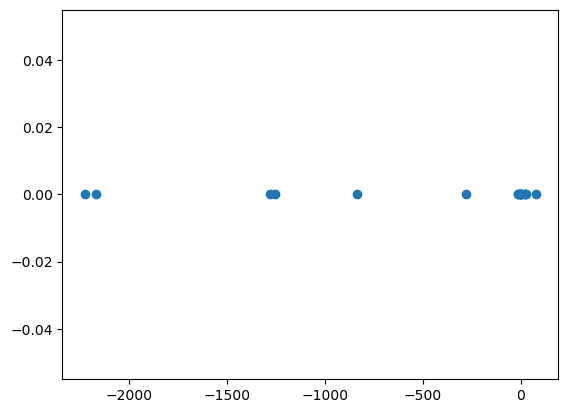

In [28]:
eigvals = scipy.linalg.eigvals(Omega2)
plt.scatter(np.real(eigvals), np.imag(eigvals))

In [30]:
Omega2

Quantity(value=array([[-7.98571393e+02, -5.52568234e+01, -3.79689480e+02,
         9.04716199e+01, -2.16650122e+02,  1.05449885e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.88732513e+02,  2.86746724e+02,  3.81135514e+01,
         1.39323762e+02, -3.98087027e+00,  6.33424000e+01],
       [-5.52568234e+01, -7.24500797e+02,  1.45789895e+02,
        -2.16650122e+02,  3.56878409e+02, -1.88620534e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.86746724e+02,  3.44897524e+02,  4.98798457e+01,
        -3.98087027e+00,  6.09609767e+00, -1.89099723e+00],
       [-3.79689480e+02,  1.45789895e+02, -1.71862471e+02,
         1.05449885e+02, -1.88620534e+02,  6.11586323e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.81135514e+01,  4.98798457e+0

In [34]:
scipy.linalg.eig(np.array([[0,1+0j],[0,0]]))

(array([0.+0.j, 0.+0.j]),
 array([[ 1.00000000e+000+0.j,  1.00000000e+000+0.j],
        [ 0.00000000e+000+0.j, -2.00416836e-292-0.j]]))

In [36]:
scipy.linalg.expm(np.array([[2,1],[0,2]]))

array([[7.3890561, 7.3890561],
       [0.       , 7.3890561]])